In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sc
import dataframe_image as dfi
from scipy.stats import norm
import time

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
np.random.seed(42)

In [4]:
sns.set_style("dark")

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Helper functions

In [6]:
def excel_to_csv (excel_file_name, suffixe, cols_droped=[0,1,3]):
    
    df_excel = pd.read_excel(excel_file_name, parse_dates=False, sheet_name=None, header=3)
    nbr_sheet = len(list(df_excel.values()))
    delete_list = ['CHF',  'EUR', 'GBP', 'Autre', 'USD', 'Autres',
                                  'NON EUR', 'CAD', 'AUD', 'JPY', 'EMCUR',
                                  'Courbe CHF - duration', 'Courbe EUR - duration',
                                  'Courbe USD - duration', 'Courbe Monde - duration',
                                  '% Gouvernementales - courbe CHF', '% Corporate - courbe CHF',
                                  '% Gouvernementales - courbe EUR', '% Corporate - courbe EUR',
                                  '% Gouvernementales - courbe USD', '% Corporate - courbe USD',
                                  '% Gouvernementales - courbe Monde', '% Corporate - courbe Monde',
                                  '% Gouvernementales - Courbe CHF', '% Corporate - Courbe CHF',
                                  '% Gouvernementales - Courbe EUR', '% Corporate - Courbe EUR',
                                  '% Gouvernementales - Courbe USD', '% Corporate - Courbe USD',
                                  '% Gouvernementales - Courbe Monde', '% Corporate - Courbe Monde']
    for i in range(nbr_sheet):
        df = list(df_excel.values())[i]
        sheet_name = list(df_excel.keys())[i]
        if 'No ISIN' not in df.columns:
            continue
        df.dropna(how='all', inplace=True)
        df = df[df['No ISIN'].notna()]
        df = df[-df['No ISIN'].isin(delete_list)]
        df.drop(df.columns[cols_droped], axis=1, inplace=True)
        list_date = list(df.columns)[1:]
        df = df.melt(id_vars='No ISIN', value_vars=list_date, var_name='histo_date', value_name='weight')
        df.dropna(subset=['weight'], inplace=True)
        df = df[df['weight'] != 0]
        df['portfolio'] = suffixe
        df['strategie'] = sheet_name
        df['weight'] = df['weight'].astype('float64')
        df['weight'] = df['weight'].round(4)
        if i==0:
            df_port = df
        if i!=0:
            df_port = pd.concat([df_port, df])
            
    return df_port

In [7]:
def port_filter(portfolio):
    
    portfolio['No ISIN'].replace({
    'Inflation Bond CHF': 'AXGICCH LX Equity',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'GSMBIAS LX Equity',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    'HYBRIDCHF': 'NBCHCPA ID Equity',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'SWBHCHP LX Equity',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'SGCIFCH LX Equity',
    'Cat Bond EUR': 'LEUPCBE SW Index',

    'LG30TRCH Index': 'H00039CH Index',
    'JPGCHFCP Index': 'CSIFMFH SW Equity',
    'Contrepartie CHF': 'CHF Curncy',
    'Contrepartie EUR': 'EUR Curncy',
    'Contrepartie USD': 'BBDXY Index',
    'AURLNCHF Curncy': 'AURLNCHF CURNCY',
    'aurlnchf curncy': 'AURLNCHF CURNCY',
    'aurlneur curncy': 'AURLNEUR CURNCY',
    'SBWG13U INDEX': 'SBWG13U Index',
    'LF89TRCH index': 'LF89TRCH Index',
    'H30909US INDEX': 'H30909US Index',
    'H30909EU INDEX': 'H30909EU Index',
    'SBWG10U INDEX': 'SBWG10U Index',
    'SBWG10CH INDEX': 'ZKWXBHN SW Equity',
    'SBWG10CH Index': 'ZKWXBHN SW Equity',
    'SBWGNSUU Index': 'IGLO LN Equity',
    'JHCC1R10 Index': 'X03H SW Equity',
    'M7CXSSD Index' : 'IJPC SW Equity'
    }, inplace=True)

    return portfolio

In [8]:
def get_all_isin(taa_port, curr=None, histo_date=None, strat=None):
    if curr is not None:
        if histo_date is None:
            if strat is None:
                all_isin = taa_port[taa_port['strategie'].str.contains(curr)]
            else:
                all_isin = taa_port[(taa_port['strategie'] == strat) & (taa_port['strategie'].str.contains(curr))]
        else:
            if strat is None:
                all_isin = taa_port[(taa_port['histo_date'] == histo_date) & (taa_port['strategie'].str.contains(curr))]
            else:
                all_isin = taa_port[(taa_port['histo_date'] == histo_date) & (taa_port['strategie'] == strat) & (taa_port['strategie'].str.contains(curr))]
    else:
        if histo_date is None:
            all_isin = taa_port
        else:
            all_isin = taa_port[taa_port['histo_date'] == histo_date]
        
    return pd.DataFrame(all_isin['No ISIN'].unique(), columns=['No ISIN'])

In [9]:
def get_all_strat(taa_port, curr=None):
    if curr is not None:
        all_strat = list(taa_port[taa_port.strategie.str.contains(curr)]['strategie'].unique())
    else:
        all_strat = list(taa_port['strategie'].unique())
        
    return all_strat

In [10]:
def get_weight(taa_port, strategie, histo_date):
    return taa_port[(taa_port['strategie'] == strategie) & (taa_port['histo_date'] == histo_date)][['No ISIN', 'weight']]

In [11]:
def get_all_dates(taa_port, strat=None):
    if strat is not None:
        all_dates = taa_port[taa_port.strategie == strat]['histo_date'].unique()
    else:
        all_dates = taa_port['histo_date'].unique()
    return all_dates

In [12]:
def round_nearest(x, a):
    return round(x / a) * a

In [13]:
def data_filter(data_excel, port, curr, strat=None, date=None):   
    data = data_excel.copy()
    all_isin_port = get_all_isin(port, strat=strat, curr=curr, histo_date=date)
    list_isin = list(all_isin_port['No ISIN'])
    data = data[list_isin]
    num_assets_data = data.shape[1]
    return data

In [14]:
def get_ret_cov(data):  
    daily_returns = data.pct_change()
    annual_returns = ((1 + daily_returns.mean())**252 - 1).values
    daily_cov = daily_returns.cov()
    annual_cov = daily_cov.values * 252
    return annual_returns, annual_cov

In [15]:
def sigma_to_sharp (weights, annual_returns, annual_cov):
    
    port_ret = weights @ annual_returns
    port_vol = np.sqrt(weights.T @ annual_cov @ weights )
    if port_vol == 0:
        port_sharp = 0
    else:
        port_sharp = port_ret / port_vol
    
    return port_ret, port_vol, port_sharp

# Data preparation

In [16]:
port_concur = pd.read_excel('PP_data/saa_concurrents.xlsx', parse_dates=False, sheet_name='Feuil1', header=3)
port_concur.drop(port_concur.columns[[0,1]], axis=1, inplace=True)
port_concur = port_concur.rename(columns={'Ticker': 'No ISIN'})
port_concur = port_concur[port_concur['No ISIN'].notna()]
port_concur.drop(port_concur.columns[26:], axis=1, inplace=True)
list_concurrents = list(port_concur.columns)[1:]
port_concur = port_concur.melt(id_vars='No ISIN', value_vars=list_concurrents, var_name='concurrent', value_name='weight')
port_concur.dropna(subset=['weight'], inplace=True)
port_concur = port_concur[port_concur['weight'] != 0]
port_concur = port_filter(port_concur)

In [17]:
all_concurrents = list(port_concur['concurrent'].unique())
all_concurrents.remove('Modéré CHF')
all_concurrents.remove('Actions CHF')
all_concurrents.remove('Engagé CHF')
all_concurrents.remove('Dynamique CHF')
all_concurrents.remove('Equilibré CHF')
all_concurrents.remove('BCVs Conservative')
all_concurrents.remove('BCVs Pension 35')
all_concurrents.remove('BCVs Opportunity')

In [18]:
all_concurrents_modéré = ['BCV Modéré', 'SWC Select', 'UBS Modéré', 'CS Modéré', 'SWC LPP25', 'SWC LPP40']
all_concurrents_equilibré = ['BCV Equilibré','SWC Balance', 'UBS Equilibré', 'CS Equilibré']
all_concurrents_dynamique = ['BCV Dynamique', 'SWC Ambition', 'UBS Dynamique', 'CS Dynamique']
all_concurrents_action = ['BCV Actions', 'SWC Focus', 'UBS Actions']

In [19]:
indice_excel = pd.read_excel('pp_data/fund_data.xlsx', sheet_name='indice', header=0, parse_dates=False)
indice_excel = indice_excel[['Nom', 'Valeur', 'PP_L1', 'PP_CHF_L2']].rename(columns={'Valeur': 'No ISIN'})
classe_data = port_filter(indice_excel)

In [20]:
saa_port_excel = excel_to_csv('PP_data/saa.xlsx', 'PP', [1])
saa_port_excel.drop(columns='portfolio', inplace=True)
saa_port_excel = port_filter(saa_port_excel)

In [21]:
taa_port_excel = excel_to_csv('PP_data/taa.xlsx', 'PP')
taa_port_excel.drop(columns='portfolio', inplace=True)
taa_port_excel = port_filter(taa_port_excel)

In [22]:
taa_port = taa_port_excel.copy()
saa_port = saa_port_excel.copy()

In [23]:
date = '2020-12-31'
curr = 'CHF'
port = saa_port

In [24]:
data_excel = pd.read_excel('PP_data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])
data_excel.rename(columns = { data_excel.columns[0]: "Dates" }, inplace = True)
data_excel['Dates'] = pd.to_datetime(data_excel['Dates'], yearfirst=True, format="%d/%m/%Y")
data_excel = data_excel.fillna(method='ffill')
data_excel.index = data_excel['Dates']
data_excel = data_excel.drop(columns=['Dates'])
data_excel_futur = data_excel.loc[date:]
data_excel_histo = data_excel.loc[:date]

In [25]:
all_strategies = get_all_strat(port, curr)
all_isin_port = get_all_isin(port, curr=curr, histo_date=date)

In [26]:
saa = saa_port[saa_port.strategie.str.contains('CHF') & (saa_port.histo_date == date)][['strategie', 'No ISIN', 'weight']]

In [30]:
list_isin = ['SBWMSF3L Index', 'SBF14T Index', 'SBWGNSZC Index', 
             'H00014CH Index', 'LG30TRCH Index', 'UCBIFX28 Index', 
             'SPI Index', 'MXWO Index', 'NDUEEGF Index', 'HFRXGLC Index',
             'SWIIT Index', 'AURLNCHF Curncy']
df_list_isin = pd.DataFrame(list_isin, columns=['No ISIN'])
list_isin = list(port_filter(df_list_isin)['No ISIN'])
list_nom = ['Cash CHF','Obl. Suisse','Obl. Monde','Obl. EM',
            'Obl. HY','Obl. Convertible','Actions Suisse','Actions Monde','Actions EM','Hedge Fund',
            'Real Estate','Or']
ticker_nom = pd.DataFrame(data=zip(list_isin, list_nom), columns=['ticker', 'nom'])

# Random portfolio simulation

In [105]:
data = data_filter(data_excel_histo, port, curr=curr, date=date)
data_futur = data_filter(data_excel_futur, port, curr=curr, date=date)

num_assets_data = data.shape[1]

annual_returns, annual_cov = get_ret_cov(data)
annual_returns_futur, annual_cov_futur = get_ret_cov(data_futur)

list_isin = list(get_all_isin(port, curr=curr, histo_date=date)['No ISIN'])
df_port = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'strategie'])
df_port_futur = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'strategie'])

for strat in all_strategies:
    portfolio = get_weight(port, strat, date).reset_index(drop=True)
    portfolio = pd.merge(portfolio, all_isin_port, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list_isin)
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
    port_ret_futur, port_vol_futur, port_sharpe_futur = sigma_to_sharp(weights, annual_returns_futur, annual_cov_futur)
    
    port_var = 1 - norm.ppf(alpha, (port_ret + 1), port_vol)
    port_var_futur = 1 - norm.ppf(alpha, (port_ret_futur + 1), port_vol_futur)
    
    df_temp = pd.DataFrame(data={'returns': port_ret,
                                 'volatility': port_vol,
                                 'sharpe_ratio': port_sharpe, 
                                 'var': port_var,
                                 'strategie': strat}, index=[0])
    
    df_temp_futur = pd.DataFrame(data={'returns': port_ret_futur,
                                 'volatility': port_vol_futur,
                                 'sharpe_ratio': port_sharpe_futur, 
                                 'var': port_var_futur,
                                 'strategie': strat}, index=[0])
    df_port = df_port.append(df_temp)
    df_port_futur = df_port_futur.append(df_temp_futur)
    
df_port.reset_index(drop=True, inplace=True)
df_port.strategie = df_port.strategie.str.replace(' CHF' , '')
df_port.returns *= 100
df_port.volatility *= 100

df_port_futur.reset_index(drop=True, inplace=True)
df_port_futur.strategie = df_port.strategie.str.replace(' CHF' , '')
df_port_futur.returns *= 100
df_port_futur.volatility *= 100


data = data_filter(data_excel_futur, port=port, curr=curr, date=date)
num_assets_data = data.shape[1]
annual_returns, annual_cov = get_ret_cov(data)

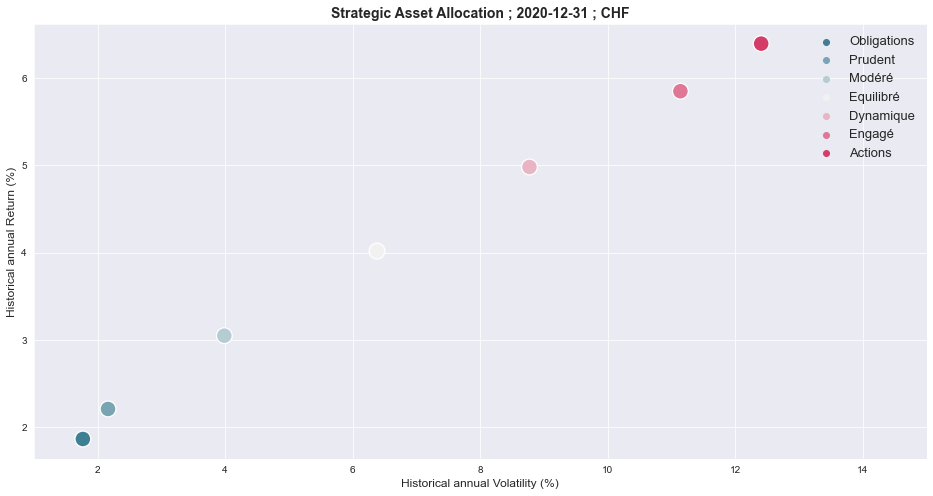

In [106]:
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(ax=ax, data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250, legend=True)
ax.legend().set_title(None)
ax.legend(fontsize=13, frameon=False)
plt.title('Strategic Asset Allocation ; ' + date + ' ; ' + curr, fontweight='bold', fontsize=14)
plt.xlabel('Historical annual Volatility (%)', fontsize=12)
plt.ylabel('Historical annual Return (%)', fontsize=12)
plt.grid()
plt.xlim(1,15)
plt.savefig('pp_output/analyse/strategies_comparison1.png', bbox_inches='tight', dpi=300)
plt.show()

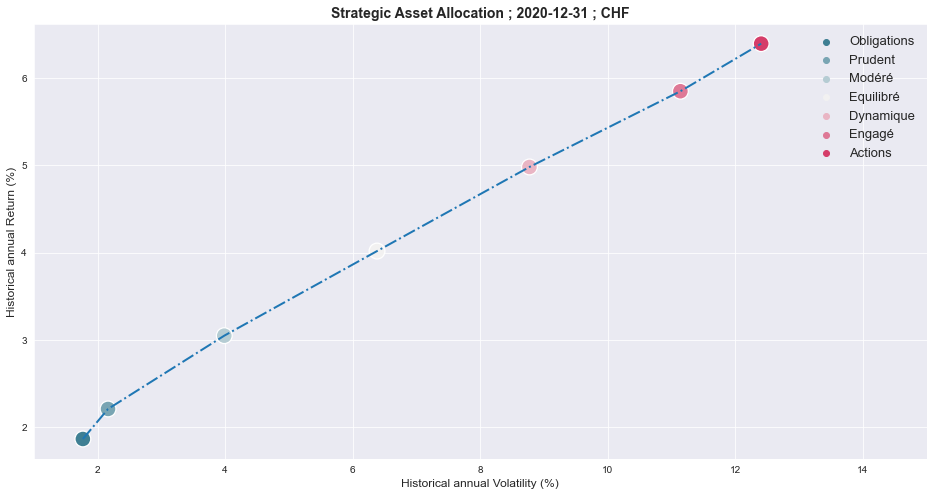

In [107]:
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(ax=ax, data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250, legend=True)
sns.lineplot(ax=ax, data=df_port, x='volatility', y='returns', lw=2, linestyle='-.')
ax.legend().set_title(None)
ax.legend(fontsize=13, frameon=False)
plt.title('Strategic Asset Allocation ; ' + date + ' ; ' + curr, fontweight='bold', fontsize=14)
plt.xlabel('Historical annual Volatility (%)', fontsize=12)
plt.ylabel('Historical annual Return (%)', fontsize=12)
plt.grid()
plt.xlim(1,15)
plt.savefig('pp_output/analyse/strategies_comparison2.png', bbox_inches='tight', dpi=300)
plt.show()

In [100]:
def weights_simulation(num_assets_data, p):
    weights = np.random.dirichlet(np.ones(num_assets_data))
    #weights = np.random.random(num_assets_data)
    weights = np.multiply(weights, np.random.binomial(1, p, size=num_assets_data))
    if np.sum(weights) != 0:
        weights /= np.sum(weights)
    return weights

In [112]:
def weights_in_bounds(df_bound, strat='Equilibré CHF'):

    if 'Obligations' in strat:
        condition = (df_bound.at['Obligations', 'weight'] > 0.80) and \
                    (df_bound.at['Obligations', 'weight'] < 0.95) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.0) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.20) and \
                    (df_bound.at['Alternatifs', 'weight'] > 0.0) and \
                    (df_bound.at['Alternatifs', 'weight'] < 0.30)
    if 'Prudent' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.00) and \
                    (df_bound.at['Actions', 'weight'] < 0.40) and \
                    (df_bound.at['Obligations', 'weight'] > 0.40) and \
                    (df_bound.at['Obligations', 'weight'] < 0.80) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.0) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.20) and \
                    (df_bound.at['Alternatifs', 'weight'] > 0.00) and \
                    (df_bound.at['Alternatifs', 'weight'] < 0.30)
    if 'Modéré' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.20) and \
                    (df_bound.at['Actions', 'weight'] < 0.60) and \
                    (df_bound.at['Obligations', 'weight'] > 0.30) and \
                    (df_bound.at['Obligations', 'weight'] < 0.70) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.0) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.20) and \
                    (df_bound.at['Alternatifs', 'weight'] > 0.0) and \
                    (df_bound.at['Alternatifs', 'weight'] < 0.30)
    if 'Equilibré' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.40) and \
                    (df_bound.at['Actions', 'weight'] < 0.60) and \
                    (df_bound.at['Obligations', 'weight'] > 0.20) and \
                    (df_bound.at['Obligations', 'weight'] < 0.50) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.00) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.20) and \
                    (df_bound.at['Alternatifs', 'weight'] > 0.00) and \
                    (df_bound.at['Alternatifs', 'weight'] < 0.30)
    if 'Dynamique' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.60) and \
                    (df_bound.at['Actions', 'weight'] < 0.90) and \
                    (df_bound.at['Obligations', 'weight'] > 0.10) and \
                    (df_bound.at['Obligations', 'weight'] < 0.50) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.00) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.20) and \
                    (df_bound.at['Alternatifs', 'weight'] > 0.00) and \
                    (df_bound.at['Alternatifs', 'weight'] < 0.30)
    if 'Engagé' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.80) and \
                    (df_bound.at['Actions', 'weight'] < 0.95) and \
                    (df_bound.at['Obligations', 'weight'] > 0.00) and \
                    (df_bound.at['Obligations', 'weight'] < 0.40) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.00) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.20)
    if 'Actions' in strat:
        condition = (df_bound.at['Actions', 'weight'] > 0.90) and \
                    (df_bound.at['Actions', 'weight'] < 1.00) and \
                    (df_bound.at['Liquidités', 'weight'] > 0.00) and \
                    (df_bound.at['Liquidités', 'weight'] < 0.20)
        
    return condition

100%|██████████| 5000/5000 [00:22<00:00, 217.86it/s]


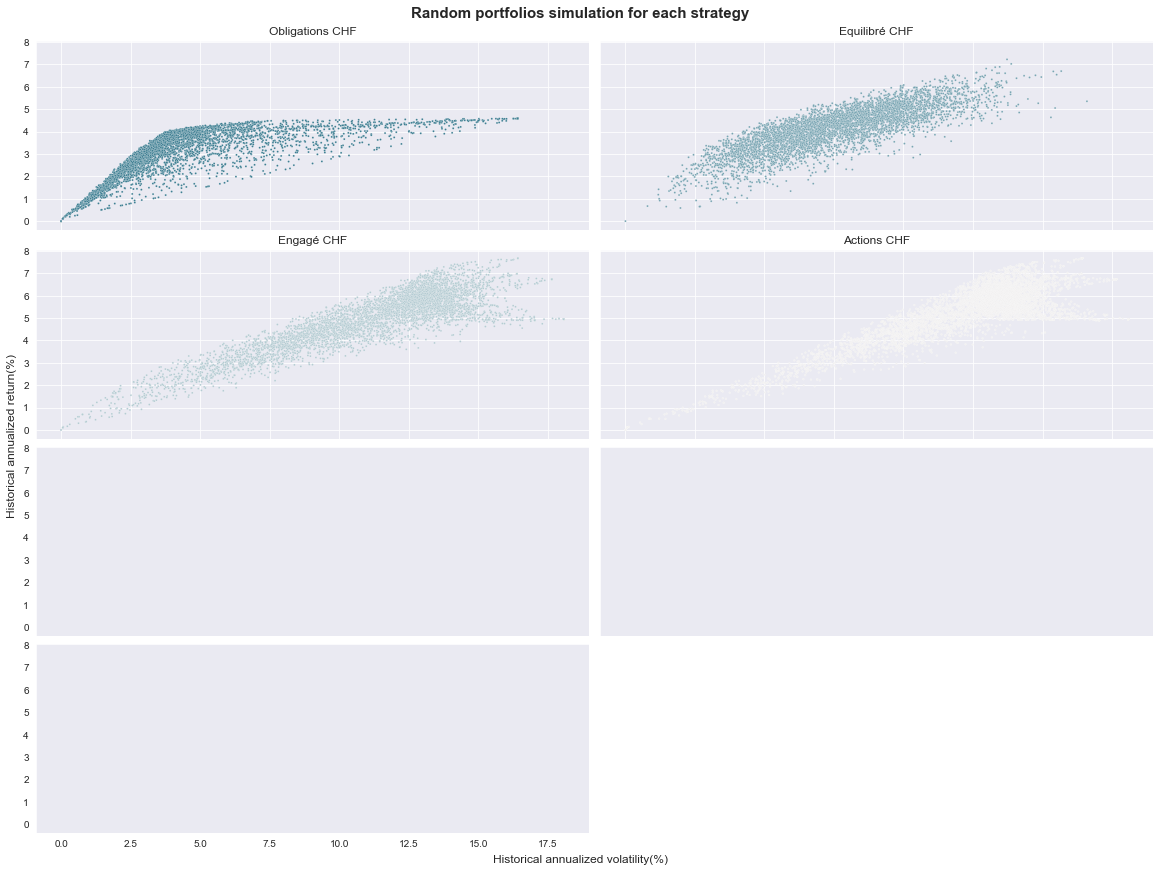

Simulation done in 87.56659889221191  seconds


In [129]:
num_portfolios = 5000
alpha = 0.05
p = 0.5

df = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'strategie'])
df_futur = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'strategie'])
df_weight = pd.DataFrame(columns=list_isin)
    
fig, axs = plt.subplots(4,2, figsize=(16,12), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()
pal = sns.diverging_palette(220, 0, n=len(all_strategies), l=50)
start_time = time.time()                        
for i, strat in enumerate(['Obligations CHF', 'Equilibré CHF', 'Engagé CHF', 'Actions CHF']):
    
    weight_list = []
    
    port_returns = []
    port_volatility = []
    port_var = []
    sharpe_ratio = []
    
    port_returns_futur = []
    port_volatility_futur = []
    port_var_futur = []
    sharpe_ratio_futur = []
    
    data = data_filter(data_excel_histo, port=port, strat=strat, curr=curr, date=date)
    data_futur = data_filter(data_excel_futur, port=port, strat=strat, curr=curr, date=date)
    list_isin_strat = list(data.columns)
    num_assets_data = data.shape[1]
    annual_returns, annual_cov = get_ret_cov(data)
    annual_returns_futur, annual_cov_futur = get_ret_cov(data_futur)
    
    for single_port in tqdm(range(num_portfolios)):
            
        weights = weights_simulation(num_assets_data, p)
        df_weight_classe = pd.DataFrame(data=zip(list_isin_strat, weights), columns=['No ISIN', 'weight']).merge(classe_data, on='No ISIN', how='left')
        df_bound = df_weight_classe.groupby('PP_L1').sum()
        
        while weights_in_bounds(df_bound, strat):
            weights = weights_simulation(num_assets_data, p)
            df_weight_classe = pd.DataFrame(data=zip(list_isin_strat, weights), columns=['No ISIN', 'weight']).merge(classe_data, on='No ISIN', how='left')
            df_bound = df_weight_classe.groupby('PP_L1').sum()
                
        
        returns, volatility, sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
        var = 1 - norm.ppf(alpha, (returns + 1), volatility)
        
        returns_futur, volatility_futur, sharpe_futur = sigma_to_sharp(weights, annual_returns_futur, annual_cov_futur)
        var_futur = 1 - norm.ppf(alpha, (returns_futur + 1), volatility_futur)

        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        port_var.append(var)
        
        sharpe_ratio_futur.append(sharpe_futur)
        port_returns_futur.append(returns_futur)
        port_volatility_futur.append(volatility_futur)
        port_var_futur.append(var_futur)
        
        weight_list.append(weights)

    df_temp = pd.DataFrame(data={'returns': port_returns,
                                 'volatility': port_volatility,
                                 'var': var,
                                 'sharpe_ratio': sharpe_ratio,
                                 'strategie': strat})
    df_temp_futur = pd.DataFrame(data={'returns': port_returns_futur,
                                 'volatility': port_volatility_futur,
                                 'var': var_futur,
                                 'sharpe_ratio': sharpe_ratio_futur,
                                 'strategie': strat})
    
    df_temp.returns *= 100
    df_temp.volatility *= 100
    
    df_temp_futur.returns *= 100
    df_temp_futur.volatility *= 100

    # df_temp = df_temp.loc[round_nearest(df_temp[['returns', 'volatility']],0.02).drop_duplicates(subset=('returns', 'volatility')).index]
    df = df.append(df_temp)
    df_futur = df_futur.append(df_temp_futur)
    
    df_weight_temp = pd.DataFrame(data=weight_list, columns=list_isin_strat)
    df_weight_temp = df_weight_temp.loc[df_temp.index]
    df_weight = pd.concat([df_weight, df_weight_temp])
                         
    axs[i].set_title(strat)
    axs[i] = sns.scatterplot(ax=axs[i], data=df_temp, x='volatility', y='returns', hue='strategie', palette=list((pal[i],)), s=4, legend=False)
    axs[i].grid()
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)
    
#df = df.loc[round_nearest(df[['returns', 'volatility']],0.02).drop_duplicates(subset=('returns', 'volatility')).index]

df_weight = df_weight.reset_index(drop=True)
df = df.reset_index(drop=True) 

df = df[df.sharpe_ratio > -1]
df_futur = df_futur[df_futur.sharpe_ratio > -1]
df_weight = df_weight.loc[df.index]

df_weight = df_weight.reset_index(drop=True)
df = df.reset_index(drop=True)

fig.delaxes(axs[7])
fig.suptitle('Random portfolios simulation for each strategy', fontsize=15, fontweight='bold')
fig.supxlabel('Historical annualized volatility(%)', fontsize=12)
fig.supylabel('Historical annualized return(%)', fontsize=12)
plt.savefig('pp_output/individual_simulation.png', bbox_inches='tight')
plt.show()
print('Simulation done in', time.time() - start_time, ' seconds')

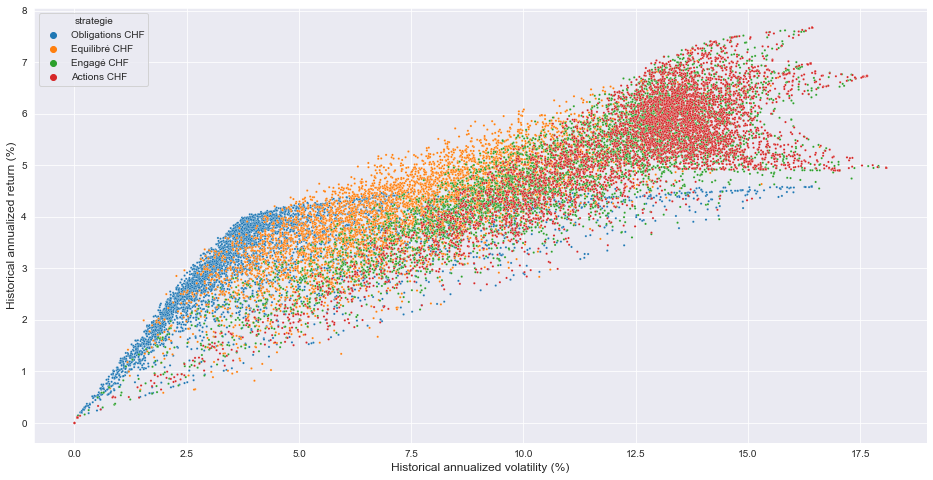

In [134]:
fig = plt.figure(figsize=(16,8))
ax = sns.scatterplot(data=df, x='volatility', y='returns', hue='strategie', s=5, legend=True)
# plt.title('Random portfolios simulation', fontsize=15, fontweight='bold')
plt.xlabel('Historical annualized volatility (%)', fontsize=12)
plt.ylabel('Historical annualized return (%)', fontsize=12)
plt.grid()
plt.savefig('pp_output/global_simulation.png', bbox_inches='tight')
plt.show()

# Comparison with strategies

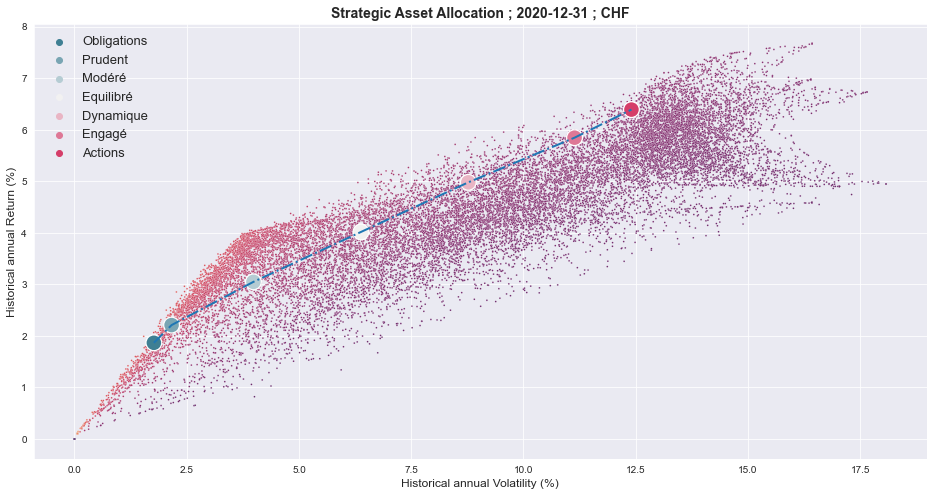

In [135]:
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=df, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
sns.scatterplot(ax=ax, data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250, legend=True)
sns.lineplot(ax=ax, data=df_port, x='volatility', y='returns', lw=2, linestyle='-.')
ax.legend().set_title(None)
ax.legend(fontsize=13, frameon=False)
plt.title('Strategic Asset Allocation ; ' + date + ' ; ' + curr, fontweight='bold', fontsize=14)
plt.xlabel('Historical annual Volatility (%)', fontsize=12)
plt.ylabel('Historical annual Return (%)', fontsize=12)
plt.grid()
#plt.xlim(1,15)
plt.savefig('pp_output/analyse/strategies_comparison3.png', bbox_inches='tight', dpi=300)
plt.show()

In [136]:
all_isin_port_concur = pd.DataFrame(port_concur['No ISIN'].unique(), columns=['No ISIN'])
list_isin_concur = list(all_isin_port_concur['No ISIN'])
df_port_concur = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'concurrent'])

data = data_excel_histo.copy()
data = data[list_isin_concur]
annual_returns, annual_cov = get_ret_cov(data)

for concur in all_concurrents:
    portfolio = port_concur[port_concur.concurrent == concur][['No ISIN', 'weight']]
    portfolio = pd.merge(portfolio, all_isin_port_concur, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list_isin_concur)
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
    port_var = 1 - norm.ppf(alpha, (port_ret + 1), port_vol)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol, 'var': port_var,
                            'sharpe_ratio': port_sharpe, 'concurrent': concur}, index=[0])
    df_port_concur = df_port_concur.append(df_temp)
    
df_port_concur.returns *= 100
df_port_concur.volatility *= 100

df_port_temp = df_port.copy()
df_port_temp.strategie = 'BCVs ' + df_port.strategie.str.replace(' CHF' , '')
df_port_all = pd.concat([df_port_temp, df_port_concur.rename(columns={'concurrent': 'strategie'})]).reset_index(drop=True)
df_port_all['institution'] = df_port_all.strategie.str.split().str.get(0)
df_port_all = df_port_all[~df_port_all.strategie.isin(['SWC LPP25','SWC LPP40'])]

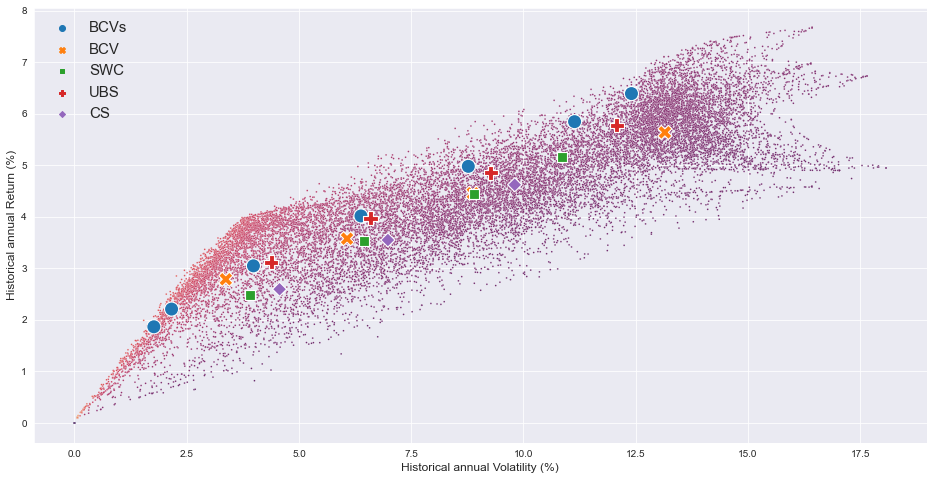

In [137]:
fig, ax = plt.subplots(figsize=(16,8))

num_instit = df_port_all['institution'].nunique()
pal = 'tab10'
#pal = sns.color_palette("hls", n_colors=num_instit)
# rouge vert

sns.scatterplot(data=df, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
sns.scatterplot(data=df_port_all, x='volatility', y='returns', hue='institution', style='institution', s=200, palette=pal, legend=True)

ax.legend().set_title(None)
ax.legend(fontsize=15, frameon=False)
#plt.title('Risk and return comparison between concurrents; ' + date + ' ; ' + curr, fontweight='bold', fontsize=15)
plt.xlabel('Historical annual Volatility (%)', fontsize=12)
plt.ylabel('Historical annual Return (%)', fontsize=12)
plt.grid()
plt.savefig('pp_output/analyse/concurrents_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

# Comparison between historical and futur risk and performance

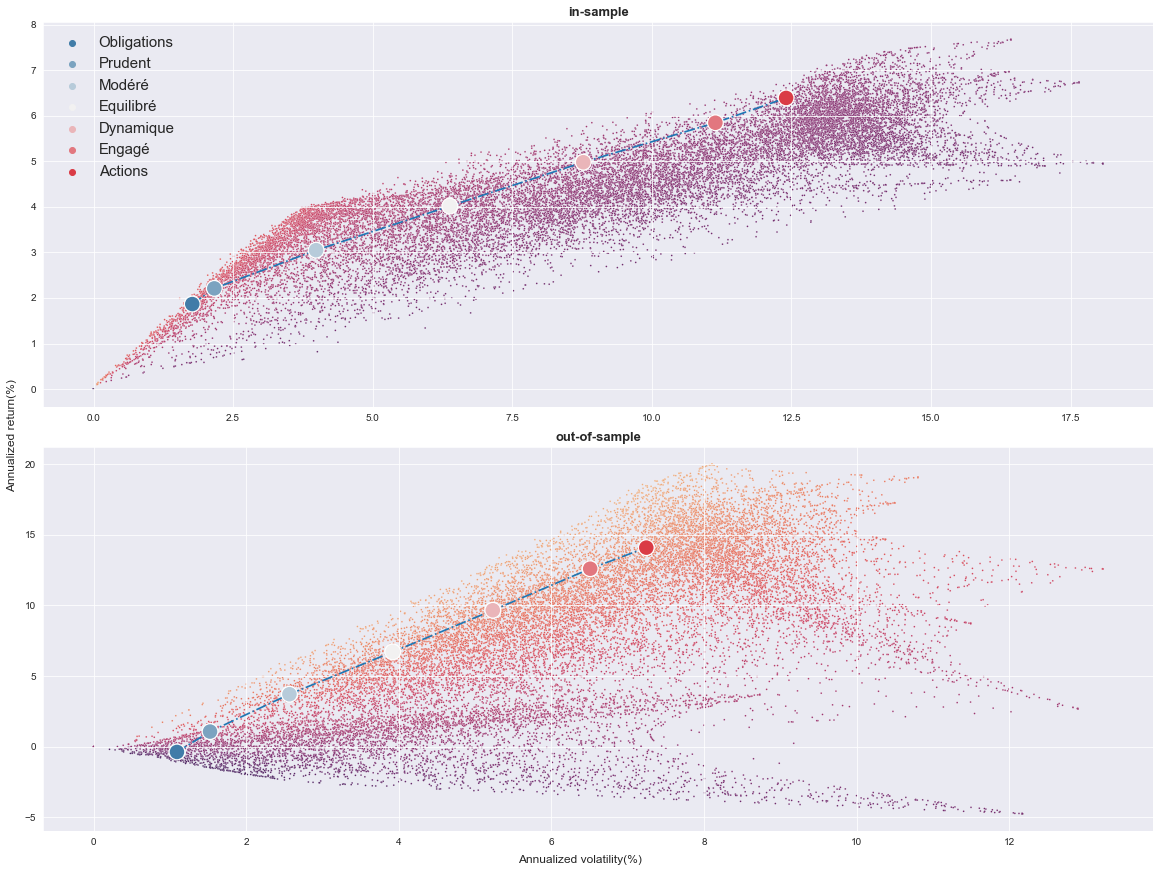

In [138]:
fig, axs = plt.subplots(2,1, figsize=(16,12), sharex=False, sharey=False, constrained_layout=True)
axs = axs.ravel()

pal = sns.diverging_palette(240, 10, n=len(all_strategies), l=50)

sns.scatterplot(ax=axs[0], data=df, x='volatility', y='returns', hue='sharpe_ratio', palette="flare_r", s=3, legend=False, zorder=0)
sns.scatterplot(ax=axs[0], data=df_port, x='volatility', y='returns', hue='strategie', palette=pal, s=250, zorder=2)
sns.lineplot(ax=axs[0], data=df_port, x='volatility', y='returns', lw=1.7, linestyle='-.', zorder=1)

axs[0].grid()
axs[0].set_title('in-sample', fontsize=13, fontweight='bold')
axs[0].set(xlabel=None)
axs[0].set(ylabel=None)
axs[0].legend().set_title(None)
axs[0].legend(fontsize=15, frameon=False)

sns.scatterplot(ax=axs[1], data=df_futur, x='volatility', y='returns', hue='sharpe_ratio', palette='flare_r', s=3, legend=False, zorder=0)
sns.scatterplot(ax=axs[1], data=df_port_futur, x='volatility', y='returns', hue='strategie', palette=pal, s=250, legend=False, zorder=2)
sns.lineplot(ax=axs[1], data=df_port_futur, x='volatility', y='returns', lw=1.7, linestyle='-.', zorder=1)
axs[1].grid()
axs[1].set_title('out-of-sample', fontsize=13, fontweight='bold')
axs[1].set(xlabel=None)
axs[1].set(ylabel=None)
#axs[1].legend().set_title(None)

#fig.suptitle('Efficient frontier comparison between historical and futur price data', fontsize=15, fontweight='bold')
fig.supxlabel('Annualized volatility(%)', fontsize=12)
fig.supylabel('Annualized return(%)', fontsize=12)
plt.savefig('pp_output/analyse/historical_futur.png', bbox_inches='tight', dpi=300)
plt.show()

In [140]:
all_isin_port_concur = pd.DataFrame(port_concur['No ISIN'].unique(), columns=['No ISIN'])
list_isin_concur = list(all_isin_port_concur['No ISIN'])
df_port_concur = pd.DataFrame(columns=['returns', 'volatility', 'var', 'sharpe_ratio', 'concurrent'])

data = data_excel_futur.copy()
data = data[list_isin_concur]
annual_returns, annual_cov = get_ret_cov(data)

for concur in all_concurrents:
    portfolio = port_concur[port_concur.concurrent == concur][['No ISIN', 'weight']]
    portfolio = pd.merge(portfolio, all_isin_port_concur, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list_isin_concur)
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
    port_var = 1 - norm.ppf(alpha, (port_ret + 1), port_vol)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol, 'var': port_var,
                            'sharpe_ratio': port_sharpe, 'concurrent': concur}, index=[0])
    df_port_concur = df_port_concur.append(df_temp)
    
df_port_concur.returns *= 100
df_port_concur.volatility *= 100

df_port_temp = df_port_futur.copy()
df_port_temp.strategie = 'BCVs ' + df_port.strategie.str.replace(' CHF' , '')
df_port_all_futur = pd.concat([df_port_temp, df_port_concur.rename(columns={'concurrent': 'strategie'})]).reset_index(drop=True)
df_port_all_futur['institution'] = df_port_all_futur.strategie.str.split().str.get(0)

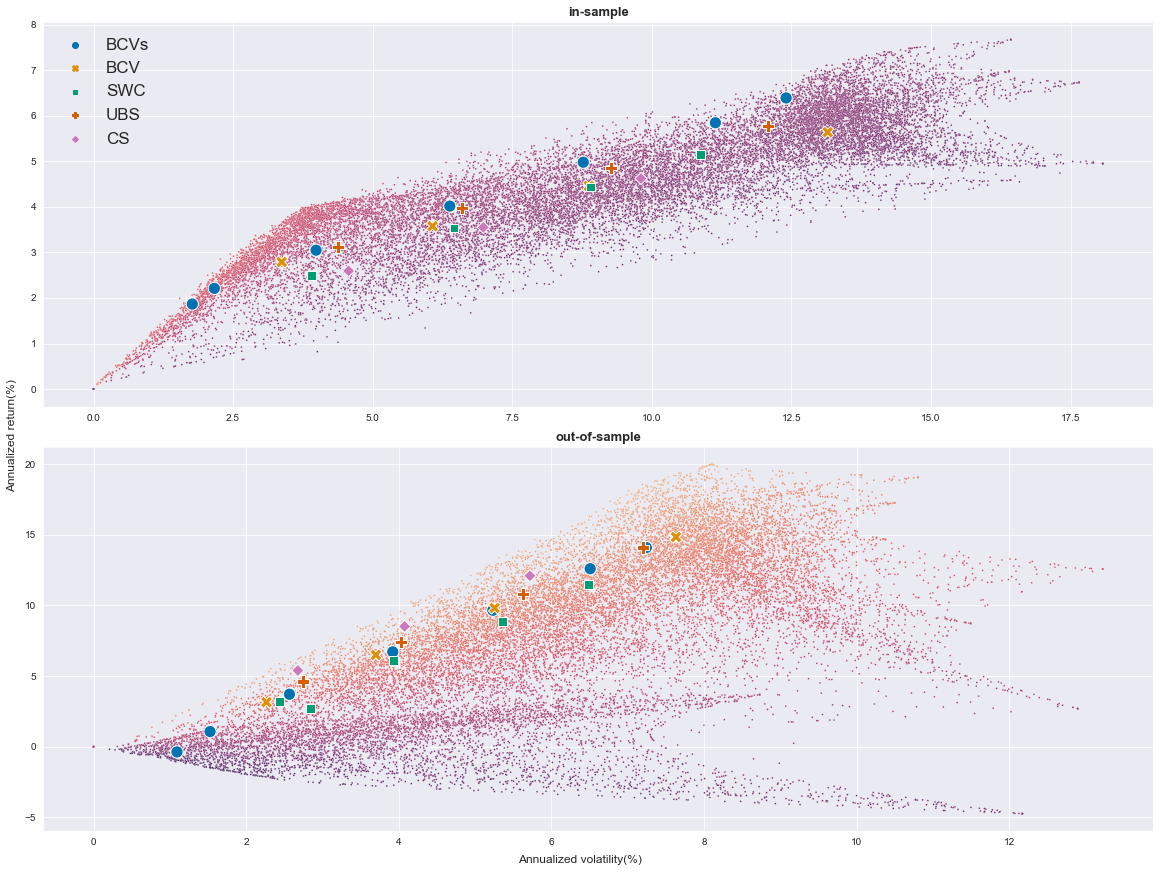

In [141]:
fig, axs = plt.subplots(2,1, figsize=(16,12), sharex=False, sharey=False, constrained_layout=True)
axs = axs.ravel()

pal = 'colorblind'

sns.scatterplot(ax=axs[0], data=df, x='volatility', y='returns', hue='sharpe_ratio', palette='flare_r', s=3, legend=False)
sns.scatterplot(ax=axs[0], data=df_port_all, x='volatility', y='returns', hue='institution', style='institution', s=150, palette=pal, legend=True)

axs[0].grid()
axs[0].set_title('in-sample', fontsize=13, fontweight='bold')
axs[0].set(xlabel=None)
axs[0].set(ylabel=None)
axs[0].legend().set_title(None)
axs[0].legend(fontsize=17, frameon=False)

sns.scatterplot(ax=axs[1], data=df_futur, x='volatility', y='returns', hue='sharpe_ratio', palette='flare_r', s=3, legend=False)
sns.scatterplot(ax=axs[1], data=df_port_all_futur, x='volatility', y='returns', hue='institution', style='institution', s=150, palette=pal, legend=False)

axs[1].grid()
axs[1].set_title('out-of-sample', fontsize=13, fontweight='bold')
axs[1].set(xlabel=None)
axs[1].set(ylabel=None)

#fig.suptitle('Efficient frontier comparison between historical and futur price data', fontsize=15, fontweight='bold')
fig.supxlabel('Annualized volatility(%)', fontsize=12)
fig.supylabel('Annualized return(%)', fontsize=12)
plt.savefig('pp_output/analyse/historical_futur_conccurents.png', bbox_inches='tight', dpi=300)
plt.show()

In [142]:
list_isin = ['SBWMSF3L Index', 'SBF14T Index', 'SBWGNSZC Index', 
             'H00014CH Index', 'LG30TRCH Index', 'UCBIFX28 Index', 
             'SPI Index', 'MXWO Index', 'NDUEEGF Index', 'HFRXGLC Index',
             'SWIIT Index', 'AURLNCHF Curncy']
df_list_isin = pd.DataFrame(list_isin, columns=['No ISIN'])
list_isin = list(port_filter(df_list_isin)['No ISIN'])
list_nom = ['Cash CHF','Obl. Suisse','Obl. Monde','Obl. EM',
            'Obl. HY','Obl. Convertible','Actions Suisse','Actions Monde','Actions EM','Hedge Fund',
            'Real Estate','Or']
ticker_nom = pd.DataFrame(data=zip(list_isin, list_nom), columns=['ticker', 'nom'])

In [143]:
list_saa = [0.05, 0.23, 0.075, 0.015, 0.015, 0.015, 0.189, 0.227, 0.064, 0.06, 0.03, 0.03]
saa_grouped = pd.DataFrame(zip(list_isin, list_nom, list_saa), columns=['Ticker', 'Nom', 'weight'])

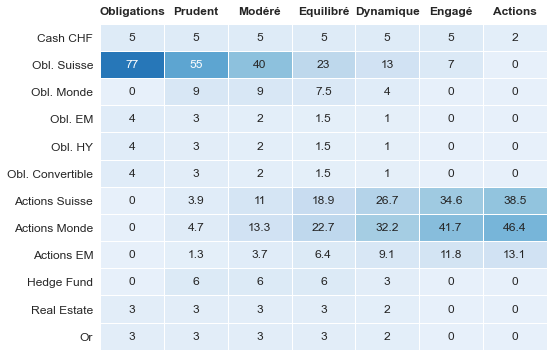

In [144]:
actions_monde = ['MSDEEMUN Index', 'NDDLCA Index', 'NDDLJN Index', 'NDDLUK Index', 'NDDLUS Index', 'NDDUPXJ Index']

saa_resume = (saa.pivot(index='No ISIN', columns='strategie', values='weight').fillna(0) * 100).round(2)
saa_resume.index.name = None
saa_resume.columns.name = None
world_weight = saa_resume.loc[actions_monde].sum()
saa_resume = saa_resume[~saa_resume.index.isin(world_weight)]
saa_resume.loc['MXWO Index'] = world_weight
saa_resume = saa_resume.reindex(list_isin)
saa_resume.index = list_nom
saa_resume.columns = saa_resume.columns.str.replace(' CHF', '')
saa_resume = saa_resume[['Obligations', 'Prudent', 'Modéré', 'Equilibré', 'Dynamique', 'Engagé', 'Actions']]

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(data=saa_resume.round(1).astype(float), annot=True, cmap='Blues', annot_kws=dict(size=12), cbar=False, vmin=-10, vmax=110, linewidths=1, fmt='.3g')
ax.tick_params(axis='both', which='major', labelsize=12, labelbottom=False,labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), weight='bold')
plt.savefig('PP_output/analyse/saa.png', dpi=300, bbox_inches = "tight")
plt.xlabel
plt.show()

In [54]:
data = data_excel_histo.copy().fillna(method='ffill')
data = data[list_isin]
data_futur = data_excel_futur.copy().fillna(method='ffill')
data_futur = data_futur[list_isin]
num_assets_data = data.shape[1]

daily_returns = data.pct_change()
daily_returns.columns = list_nom
daily_returns_futur = data_futur.pct_change()
daily_returns_futur.columns = list_nom

annual_returns_histo = ((1 + daily_returns.mean())**252 - 1).values
daily_cov = daily_returns.cov()
annual_cov_histo = daily_cov.values * 252
corr = daily_returns.corr().round(2)
stats_histo = np.vstack((annual_returns_histo * 100, 
                       (daily_returns.std() * np.sqrt(252) * 100).values))
df_stats_histo = pd.DataFrame(data=stats_histo, columns=list_nom, index=['Annualized average Return (%)', 'Historical annualized Std. (%)']).round(1)

annual_returns_futur = ((1 + daily_returns_futur.mean())**252 - 1).values
daily_cov_futur = daily_returns_futur.cov()
annual_cov_futur = daily_cov_futur.values * 252
corr_futur = daily_returns_futur.corr().round(2)
stats_futur = np.vstack((annual_returns_futur * 100, 
                       (daily_returns_futur.std() * np.sqrt(252) * 100).values))
df_stats_futur = pd.DataFrame(data=stats_futur, columns=list_nom, index=['Annualized average Return (%)', 'Historical annualized Std. (%)']).round(1)

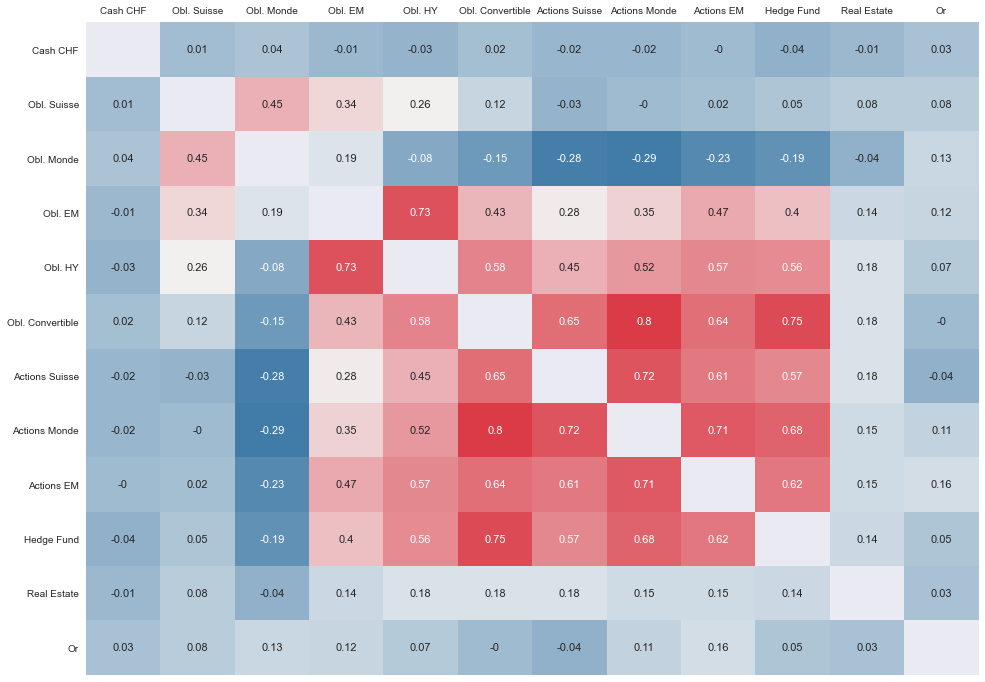

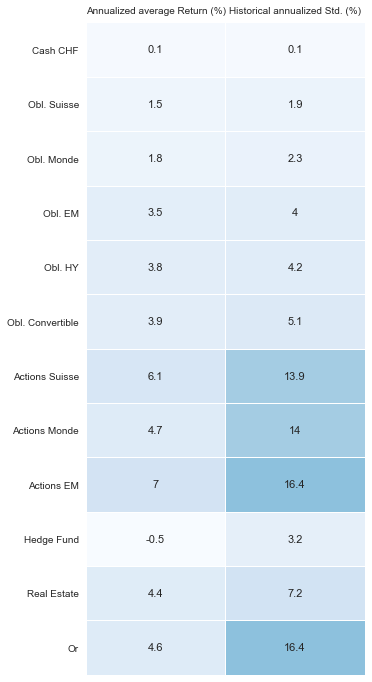

In [153]:
fig, ax = plt.subplots(figsize=(16,12))
mask = np.identity(12)
sns.heatmap(data=corr, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap=True), cbar=False, mask=mask, annot_kws=dict(size=11), fmt='.3g')
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False,labeltop=True)
plt.savefig('PP_output/analyse/correlation_histo.png', dpi=300, bbox_inches = "tight")
plt.show()
               
fig, ax = plt.subplots(figsize=(5,12))
sns.heatmap(data=df_stats_histo.T, annot=True, cmap='Blues', cbar=False, vmax=40, linewidth=1, annot_kws=dict(size=11), fmt='.3g')
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False,labeltop=True, labelrotation=0)
plt.savefig('PP_output/analyse/stats_histo.png', dpi=300, bbox_inches = "tight")
plt.show()

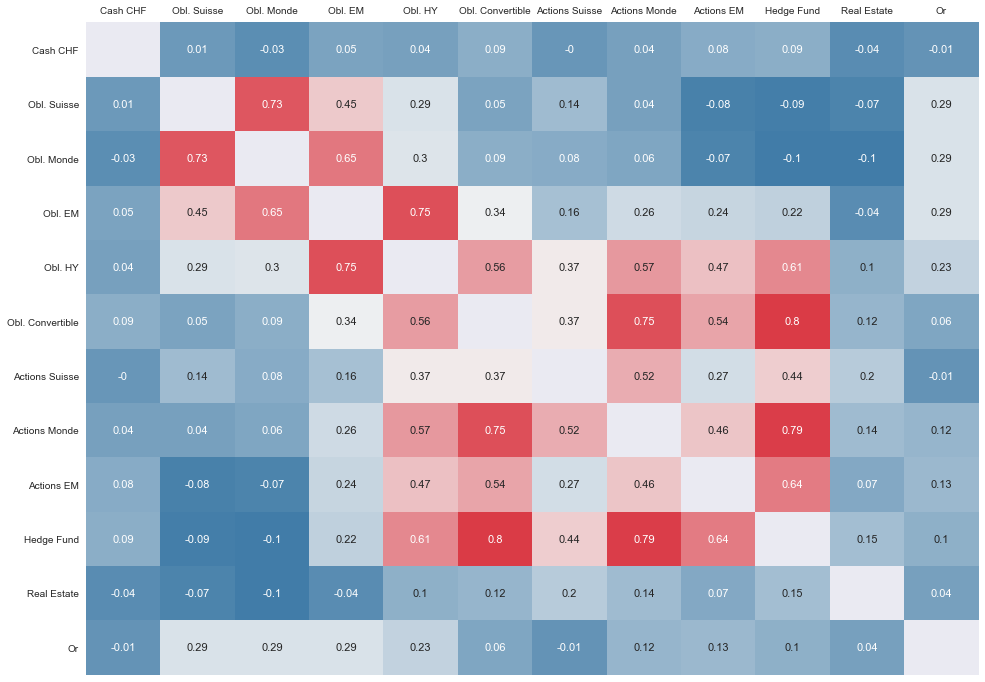

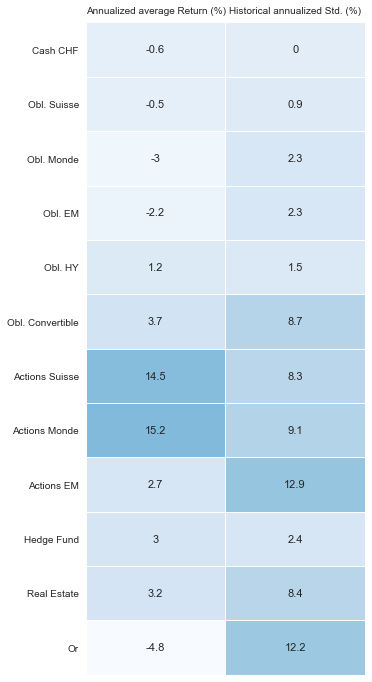

In [154]:
fig, ax = plt.subplots(figsize=(16,12))
mask = np.identity(12)
sns.heatmap(data=corr_futur, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap=True), cbar=False, mask=mask, annot_kws=dict(size=11), fmt='.3g')
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False,labeltop=True)
plt.savefig('PP_output/analyse/correlation_futur.png', dpi=300, bbox_inches = "tight")
plt.show()
               
fig, ax = plt.subplots(figsize=(5,12))
sns.heatmap(data=df_stats_futur.T, annot=True, cmap='Blues', cbar=False, vmax=40, linewidth=1, annot_kws=dict(size=11), fmt='.3g')
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False,labeltop=True, labelrotation=0)
plt.savefig('PP_output/analyse/stats_futur.png', dpi=300, bbox_inches = "tight")
plt.show()

In [57]:
def get_all_dates(taa_port, strat=None):
    if strat is not None:
        all_dates = taa_port[taa_port.strategie == strat]['histo_date'].unique()
    else:
        all_dates = taa_port['histo_date'].unique()
    return all_dates

In [480]:
taa_port_excel = excel_to_csv('PP_data/taa.xlsx', 'PP')
taa_port_excel.drop(columns='portfolio', inplace=True)
taa_port_excel = port_filter(taa_port_excel)
taa_port = taa_port_excel.copy()

In [490]:
all_dates = get_all_dates(taa_port, strat)
all_dates = all_dates[range(13, len(all_dates), 1)]
saa_date = pd.to_datetime('2020-12-31')
all_isin = get_all_isin(taa_port, curr=curr)
data = data_excel.copy()
data = data[list(all_isin['No ISIN'])]
annual_returns, annual_cov = get_ret_cov(data)

In [510]:
def volatility_comparison(all_strat, all_dates, saa_date='2020-12-31'):
    
    # SAA
    df_vol_strats_saa = pd.DataFrame(columns=all_strat)

    for strat in all_strat:

        portfolio = get_weight(saa_port, strat, saa_date).reset_index(drop=True)
        portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
        portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
        weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
        port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
        df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'date': saa_date}, index=[0])

        df_temp.reset_index(inplace=True, drop=True)
        df_vol_strats_saa[strat] = df_temp.volatility

    df_vol_strats_saa.index = df_temp.date
    df_vol_strats_saa = df_vol_strats_saa * 100

    # TAA
    df_vol_strats = pd.DataFrame(columns=all_strat)
    for i, strat in enumerate(all_strat):

        df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
        for date in all_dates:
            portfolio = get_weight(taa_port, strat, date).reset_index(drop=True)
            portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
            portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
            weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
            port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
            df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                                'sharpe_ratio': port_sharpe, 'date': date}, index=[0])
            df_port = df_port.append(df_temp)

        df_port.reset_index(inplace=True, drop=True)
        # df_port.date = df_port.date.dt.strftime('%d/%m/%Y')

        df_vol_strats[strat] = df_port.volatility

    df_vol_strats.index = df_port.date
    df_vol_strats = df_vol_strats * 100
    df_vol_strats_diff = df_vol_strats - df_vol_strats_saa.iloc[0]
    df_vol_strats_pct = (df_vol_strats - df_vol_strats_saa.iloc[0]) / df_vol_strats_saa.iloc[0]
    df_vol_strats_pct *= 100
    return df_vol_strats, df_vol_strats_diff, df_vol_strats_pct

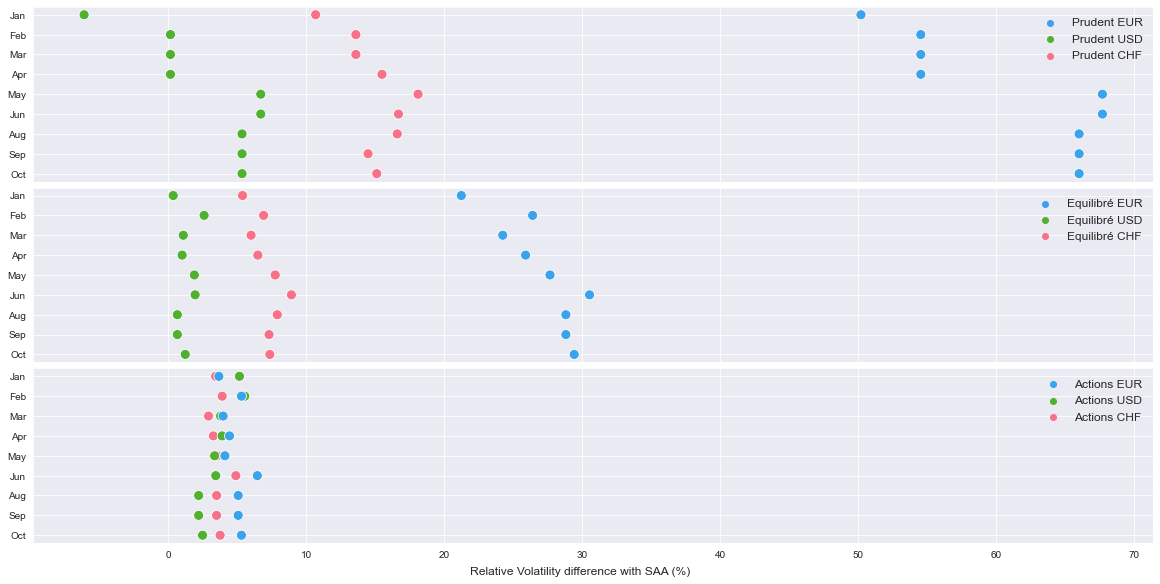

In [513]:
all_all_strats = ['Prudent', 'Equilibré', 'Actions']
all_dates = get_all_dates(taa_port, strat)
all_dates = all_dates[range(15, len(all_dates), 1)]

fig, axs = plt.subplots(3,1, figsize=(16,8), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()

for i, all_strat in enumerate(all_all_strats):
    all_strat = [all_strat + ' CHF', all_strat + ' USD',all_strat + ' EUR']
    df_vol_strats, df_vol_strats_diff, df_vol_strats_pct = volatility_comparison(all_strat, all_dates)
    
    #subplot
    data = df_vol_strats_pct.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
    data.date = data.date.dt.strftime('%b')
    
    pal = sns.color_palette("husl", 3)

    sns.scatterplot(ax=axs[i], data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100)

    handles, labels = axs[i].get_legend_handles_labels()
    lgd = axs[i].legend(reversed(handles), reversed(labels), bbox_to_anchor = (1, 1), fontsize=12, frameon=False)

    
    # plt.locator_params(axis='x', nbins=15)
    axs[i].grid(b=True, which='major', color='white', linestyle='-')
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)

#fig.suptitle('Volatility relative difference with SAA (Dec. 2020) at each rebalance date \n Comparison between currencies and strategies', fontsize=20, fontweight='bold')
fig.supxlabel('Relative Volatility difference with SAA (%)', fontsize=12)
plt.savefig('pp_output/analyse/volatility_diff_all.png', dpi=300, bbox_inches='tight')
plt.show()

In [517]:
curr = 'CHF'
all_strat = get_all_strat(taa_port, curr=curr)
all_dates = get_all_dates(taa_port, strat)
all_dates = all_dates[range(13, len(all_dates), 1)]
df_vol_strats, df_vol_strats_diff, df_vol_strats_pct = volatility_comparison(all_strat, all_dates)

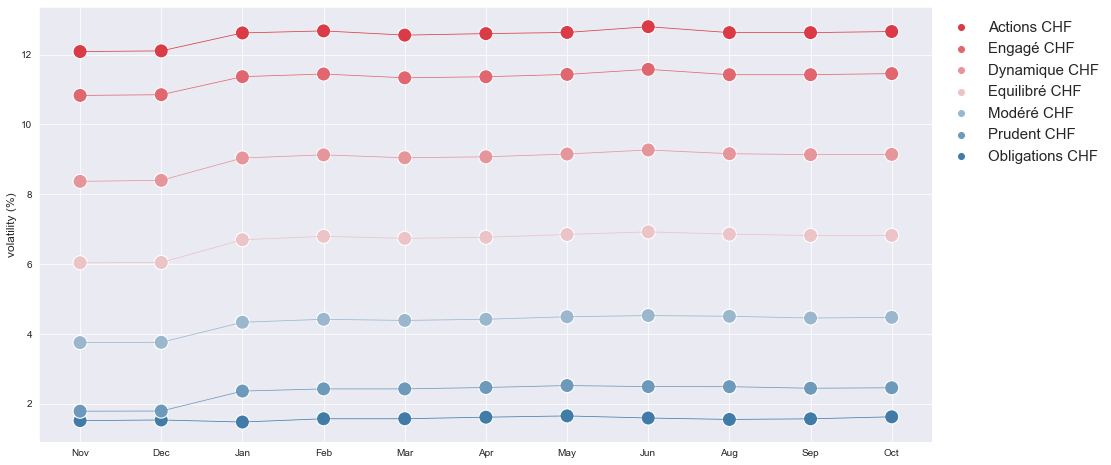

In [518]:
# display(df_vol_strats.round(2).dropna())

data = df_vol_strats.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%b')

fig = plt.figure(figsize=(16,8))
pal = sns.diverging_palette(240, 10, n=len(df_vol_strats_diff.columns) + 2)
del pal[3:5]

ax = sns.scatterplot(data=data, x='date', y='volatility', hue='strategie', palette=pal, s=200)
sns.lineplot(ax=ax, data=data, x='date', y='volatility', hue='strategie', palette=pal, lw=0.75, legend=False)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1, 1), fontsize=15, frameon=False)

plt.xlabel(None)
plt.ylabel('volatility (%)', fontsize=12)
#plt.title('Evolution of the average annualized volatility at each rebalance date (TAA) \n comparison between strategies', fontweight='bold', fontsize=15)

ax.grid(b=True, which='major', color='white', linestyle='-')

plt.savefig('pp_output/analyse/volatility_evolution.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

plt.show()

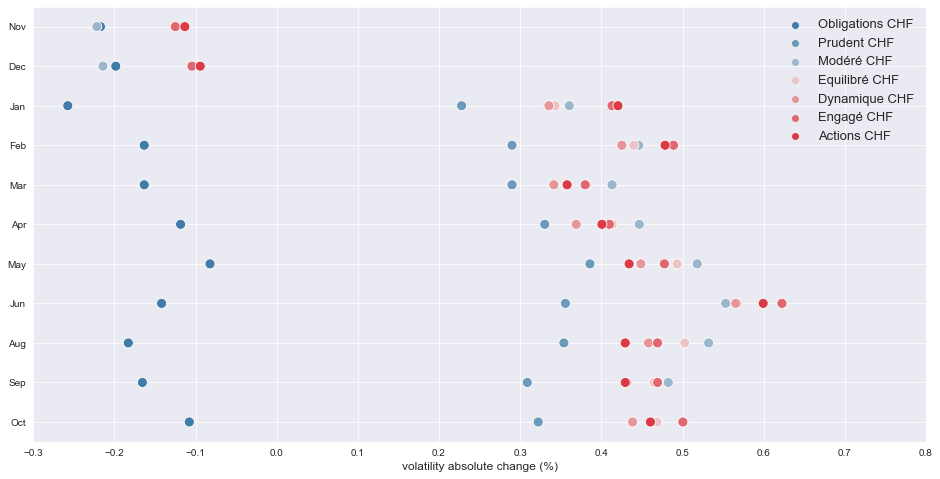

In [519]:
# display(df_vol_strats_diff.round(2).dropna())

data = df_vol_strats_diff.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%b')

fig = plt.figure(figsize=(16,8))
pal = sns.diverging_palette(240, 10, n=len(df_vol_strats_diff.columns) + 2)
del pal[3:5]

ax = sns.scatterplot(data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100, legend=True)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor = (1, 1), fontsize=13, frameon=False)

plt.ylabel(None)
plt.xlabel('volatility absolute change (%)', fontsize=12)
#plt.title('Volatility absolute difference with SAA (Dec. 2020) at each rebalance date \n Comparison between strategies', fontweight='bold', fontsize=15)
plt.locator_params(axis='x', nbins=15)
plt.xlim(-0.3, 0.8)
ax.grid(b=True, which='major', color='white', linestyle='-')


plt.savefig('pp_output/analyse/volatility_abs_diff.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

plt.show()

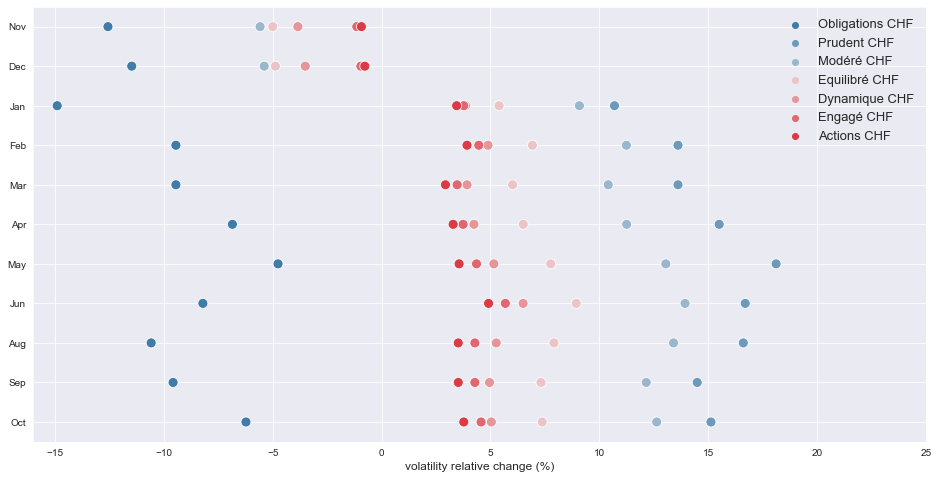

In [520]:
# display(df_vol_strats_diff.round(2).dropna())

data = df_vol_strats_pct.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%b')

fig = plt.figure(figsize=(16,8))
pal = sns.diverging_palette(240, 10, n=len(df_vol_strats_diff.columns) + 2)
del pal[3:5]

ax = sns.scatterplot(data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100, legend=True)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=(1, 1), fontsize=13, frameon=False)

plt.ylabel(None)
plt.xlabel('volatility relative change (%)', fontsize=12)
#plt.title('Volatility absolute difference with SAA (Dec. 2020) at each rebalance date \n Comparison between strategies', fontweight='bold', fontsize=15)
plt.locator_params(axis='x', nbins=15)
plt.xlim(-16, 25)
ax.grid(b=True, which='major', color='white', linestyle='-')


plt.savefig('pp_output/analyse/volatility_rel_diff.png', bbox_inches='tight', dpi=300)

plt.show()